In [2]:
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import projectscript
import scipy as sp
import scipy.signal as sig
import scipy.stats as stt

In [3]:
def my_histogram(xx,nbins):
    '''histogram with prefered parameters'''
    binwidth=(max(xx)-min(xx))/nbins
    ff,bins = np.histogram(xx,bins=nbins,density=True)[:2]
    midbins = [np.mean([bins[i:i+2]]) for i in range(len(bins)-1)]
    return midbins,ff,binwidth

def autocorr(x,y):
    '''compute autocorrelation of x and y'''
    xx = x - np.mean(x)
    yy = y - np.mean(y)
    
    denom = np.std(x)*np.std(y)*len(x)
    
    return sig.correlate(xx,yy)/denom

def welch_unc(x):
    '''get 95% CI bounds for power spectrum computed with the Welch method'''
    npseg = 2**15
    alpha = 0.05
    M = 2*len(x)//npseg -1
    dof = 4/3*M
    Pxx = sig.welch(x,nperseg=2**15)[1]
    
    return [dof*Pxx/stt.chi2.ppf(alpha/2,df=dof),dof*Pxx/stt.chi2.ppf(1-alpha/2,df=dof)]

def demean(X):
    '''remove mean from float/integer array X'''
    return np.where(np.isnan(X - np.nanmean(X,axis=0))==False,X - np.nanmean(X,axis=0),0)
    

In [3]:
temps,press,tt_mins,stations = projectscript.get_minute_data()

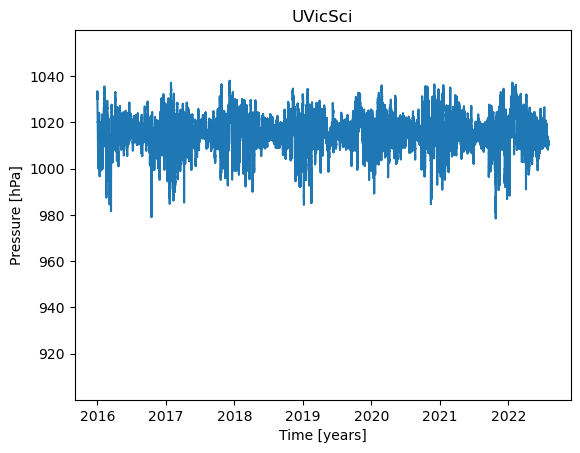

In [8]:
i = 4;name = stations[i]

#plotting time series

fig = plt.figure(figsize=(6.4, 4.8))
plt.plot(tt_mins,temps[i])
plt.xlabel('Time [years]');plt.ylabel("Temperature [$^\circ$C]")
plt.title(name)
plt.ylim(temps.min(),temps.max())
plt.savefig('Figures/tseries_temp_'+name+".png")


plt.clf()

plt.plot(tt_mins,press[i])
plt.xlabel('Time [years]');plt.ylabel("Pressure [hPa]")
plt.title(name)
plt.ylim(press.min(),press.max())
plt.savefig('Figures/tseries_press_'+name+".png")

In [12]:
# plotting histograms of temperature and pressure

fig = plt.figure(figsize=(2*6.4, 2*4.8))
for i,name in enumerate(stations):

    plt.bar(*my_histogram(temps[i],30),edgecolor='black')
    plt.xlim(temps.min(),temps.max());plt.ylim(0,0.09)
    plt.xlabel("Temperature [$^\circ$C]")
    plt.title(name)
    plt.savefig("Figures/pdf_temp_"+name+".png")
    plt.clf()
    
    
    plt.bar(*my_histogram(press[i],30),edgecolor='black')
    plt.xlim(press.min(),press.max());plt.ylim(0,0.09)
    plt.xlabel("Pressure [hPa]")
    plt.title(name)
    plt.savefig("Figures/pdf_press_"+name+".png")
    plt.clf()

<Figure size 1280x960 with 0 Axes>

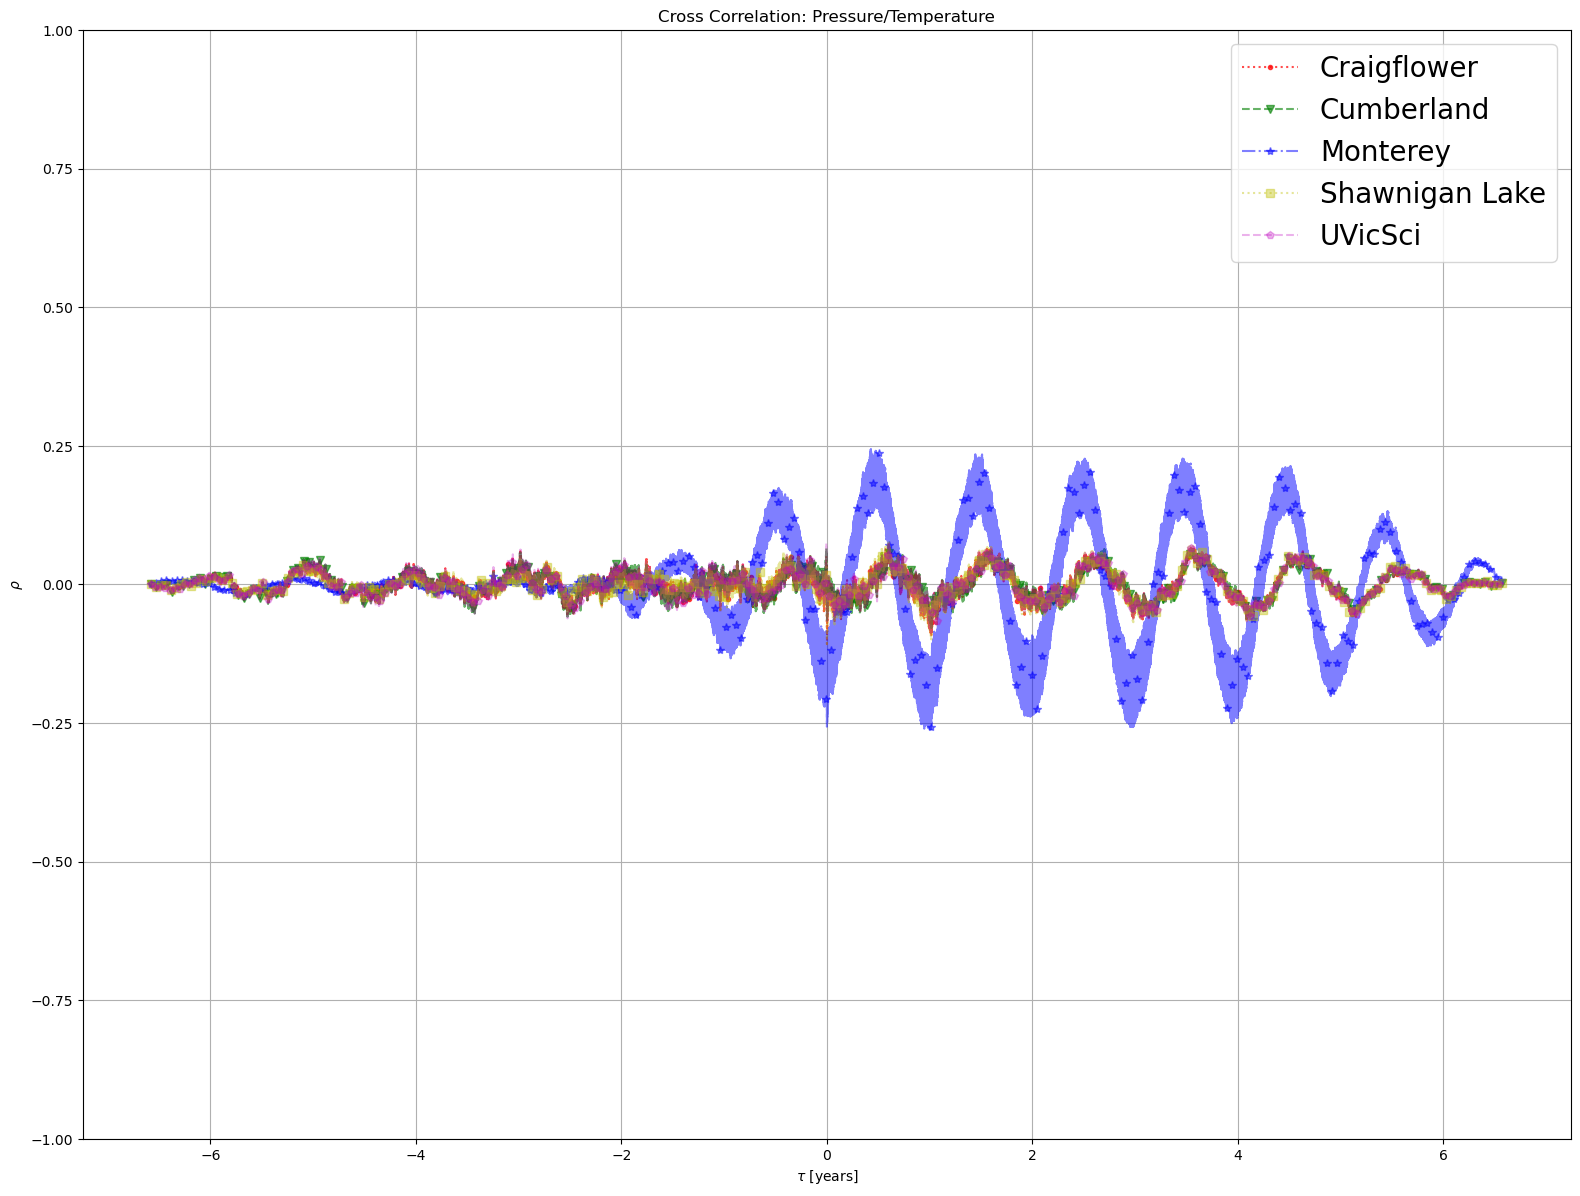

In [16]:
# plotting cross correlation between pressure and temperature for each station

tau = sig.correlation_lags(temps[0].size,temps[0].size)/525960
fig = plt.figure(figsize=(3*6.4,3*4.8))


lines = [':r.','--gv','-.b*',':ys','--mp']
alph = [0.7,0.6,0.5,0.4,0.3]
marks = [29000,28000,27000,26000,25000]

plt.title("Cross Correlation: Pressure/Temperature")
for i,name in enumerate(stations):
    pxy = autocorr(press[i],temps[i])
    plt.plot(tau,pxy,lines[i],label=stations[i],alpha=alph[i],markevery=marks[i])
    plt.ylim(-1,1)
    
plt.legend(prop={'size': 20})
plt.xlabel(r'$\tau$ [years]');plt.ylabel(r'$\rho$')
plt.grid()
plt.savefig('Figures/crosscorr_tp.png')
    

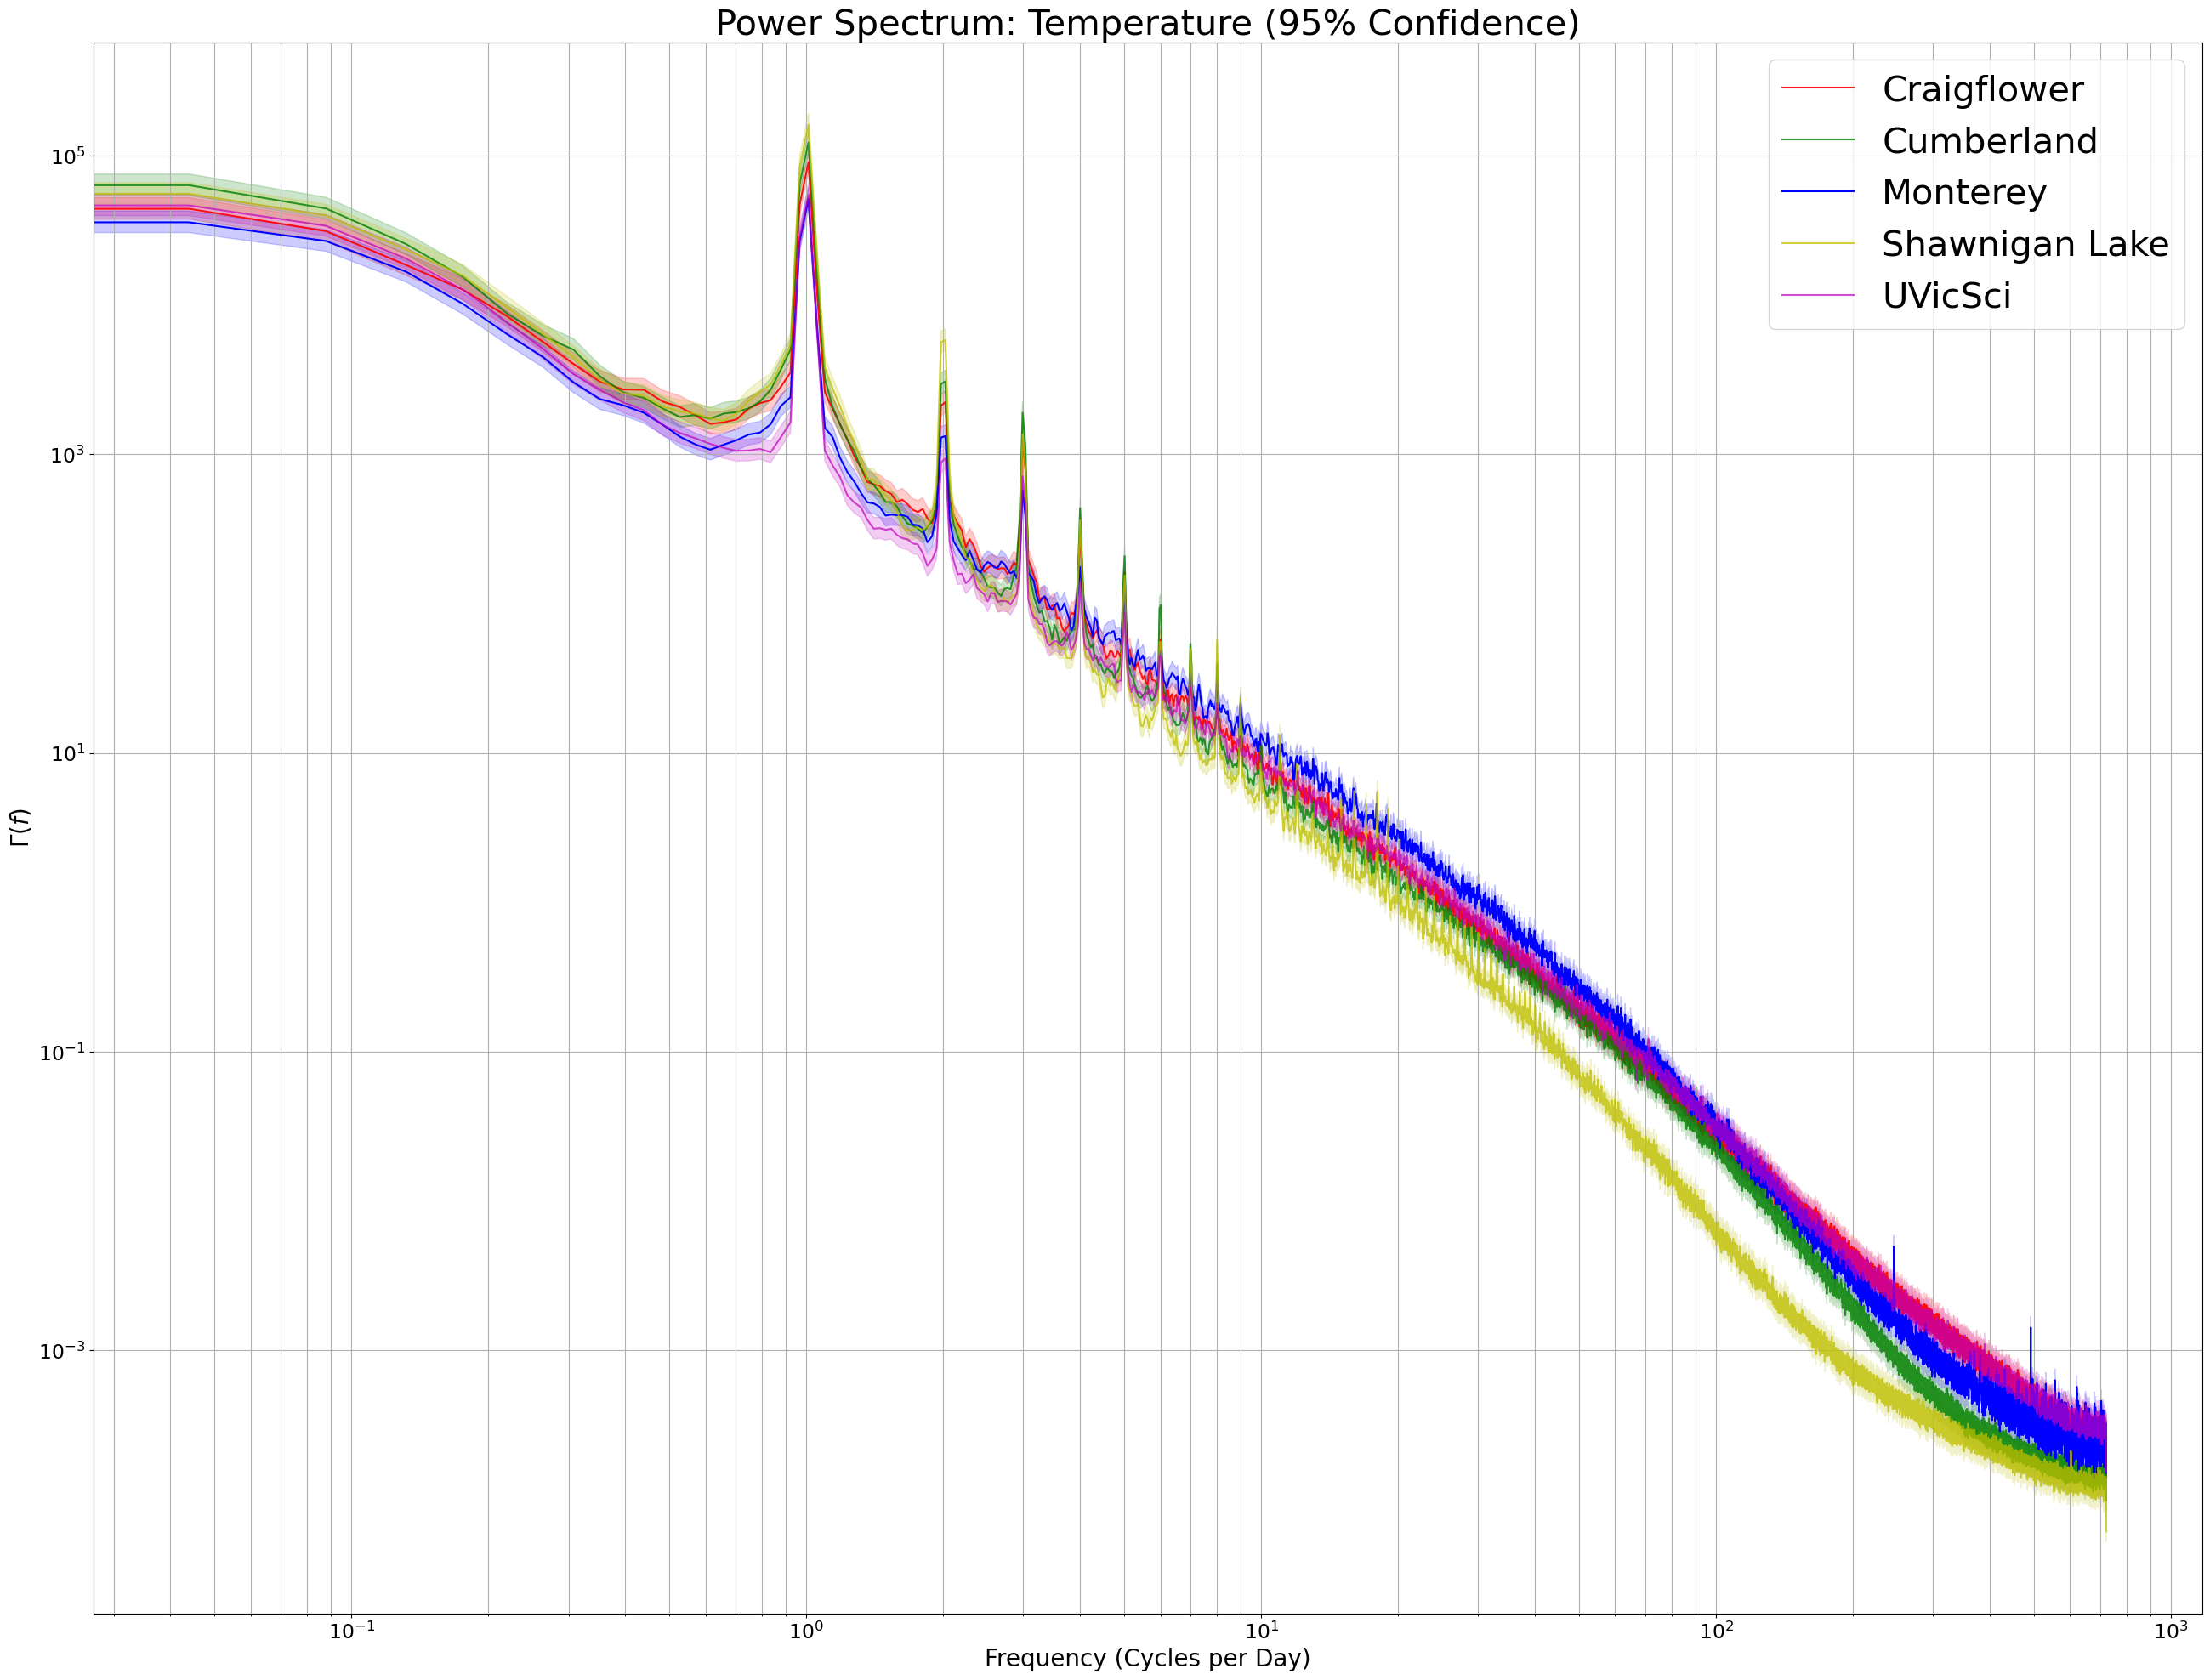

In [23]:
# plotting power spectrum

colors = ['r','g','b','y','m']

fig = plt.figure(figsize=(5*6.4,5*4.8),)
alph = [0.9,0.8,1,0.75,0.7]

for i,name in enumerate(stations):
    f,Pxx = sig.welch(temps[i],nperseg=2**15)
    bounds = welch_unc(temps[i])
    plt.loglog(f*1440,Pxx,label=name,alpha=alph[i],color=colors[i])
    plt.fill_between(f*1440,bounds[0],bounds[1],alpha=0.2,color=colors[i])

plt.grid(True, which="both")
plt.xlabel("Frequency (Cycles per Day)",size=20);plt.ylabel("$\Gamma(f)$",size=20)
plt.xticks(size=17);plt.yticks(size=17)
plt.title("Power Spectrum: Temperature (95% Confidence)",size=30)
plt.legend(prop={'size': 30})
plt.savefig("Figures/spectra_temp.png")

<Figure size 2560x1920 with 0 Axes>

<Figure size 2560x1920 with 0 Axes>

<Figure size 2560x1920 with 0 Axes>

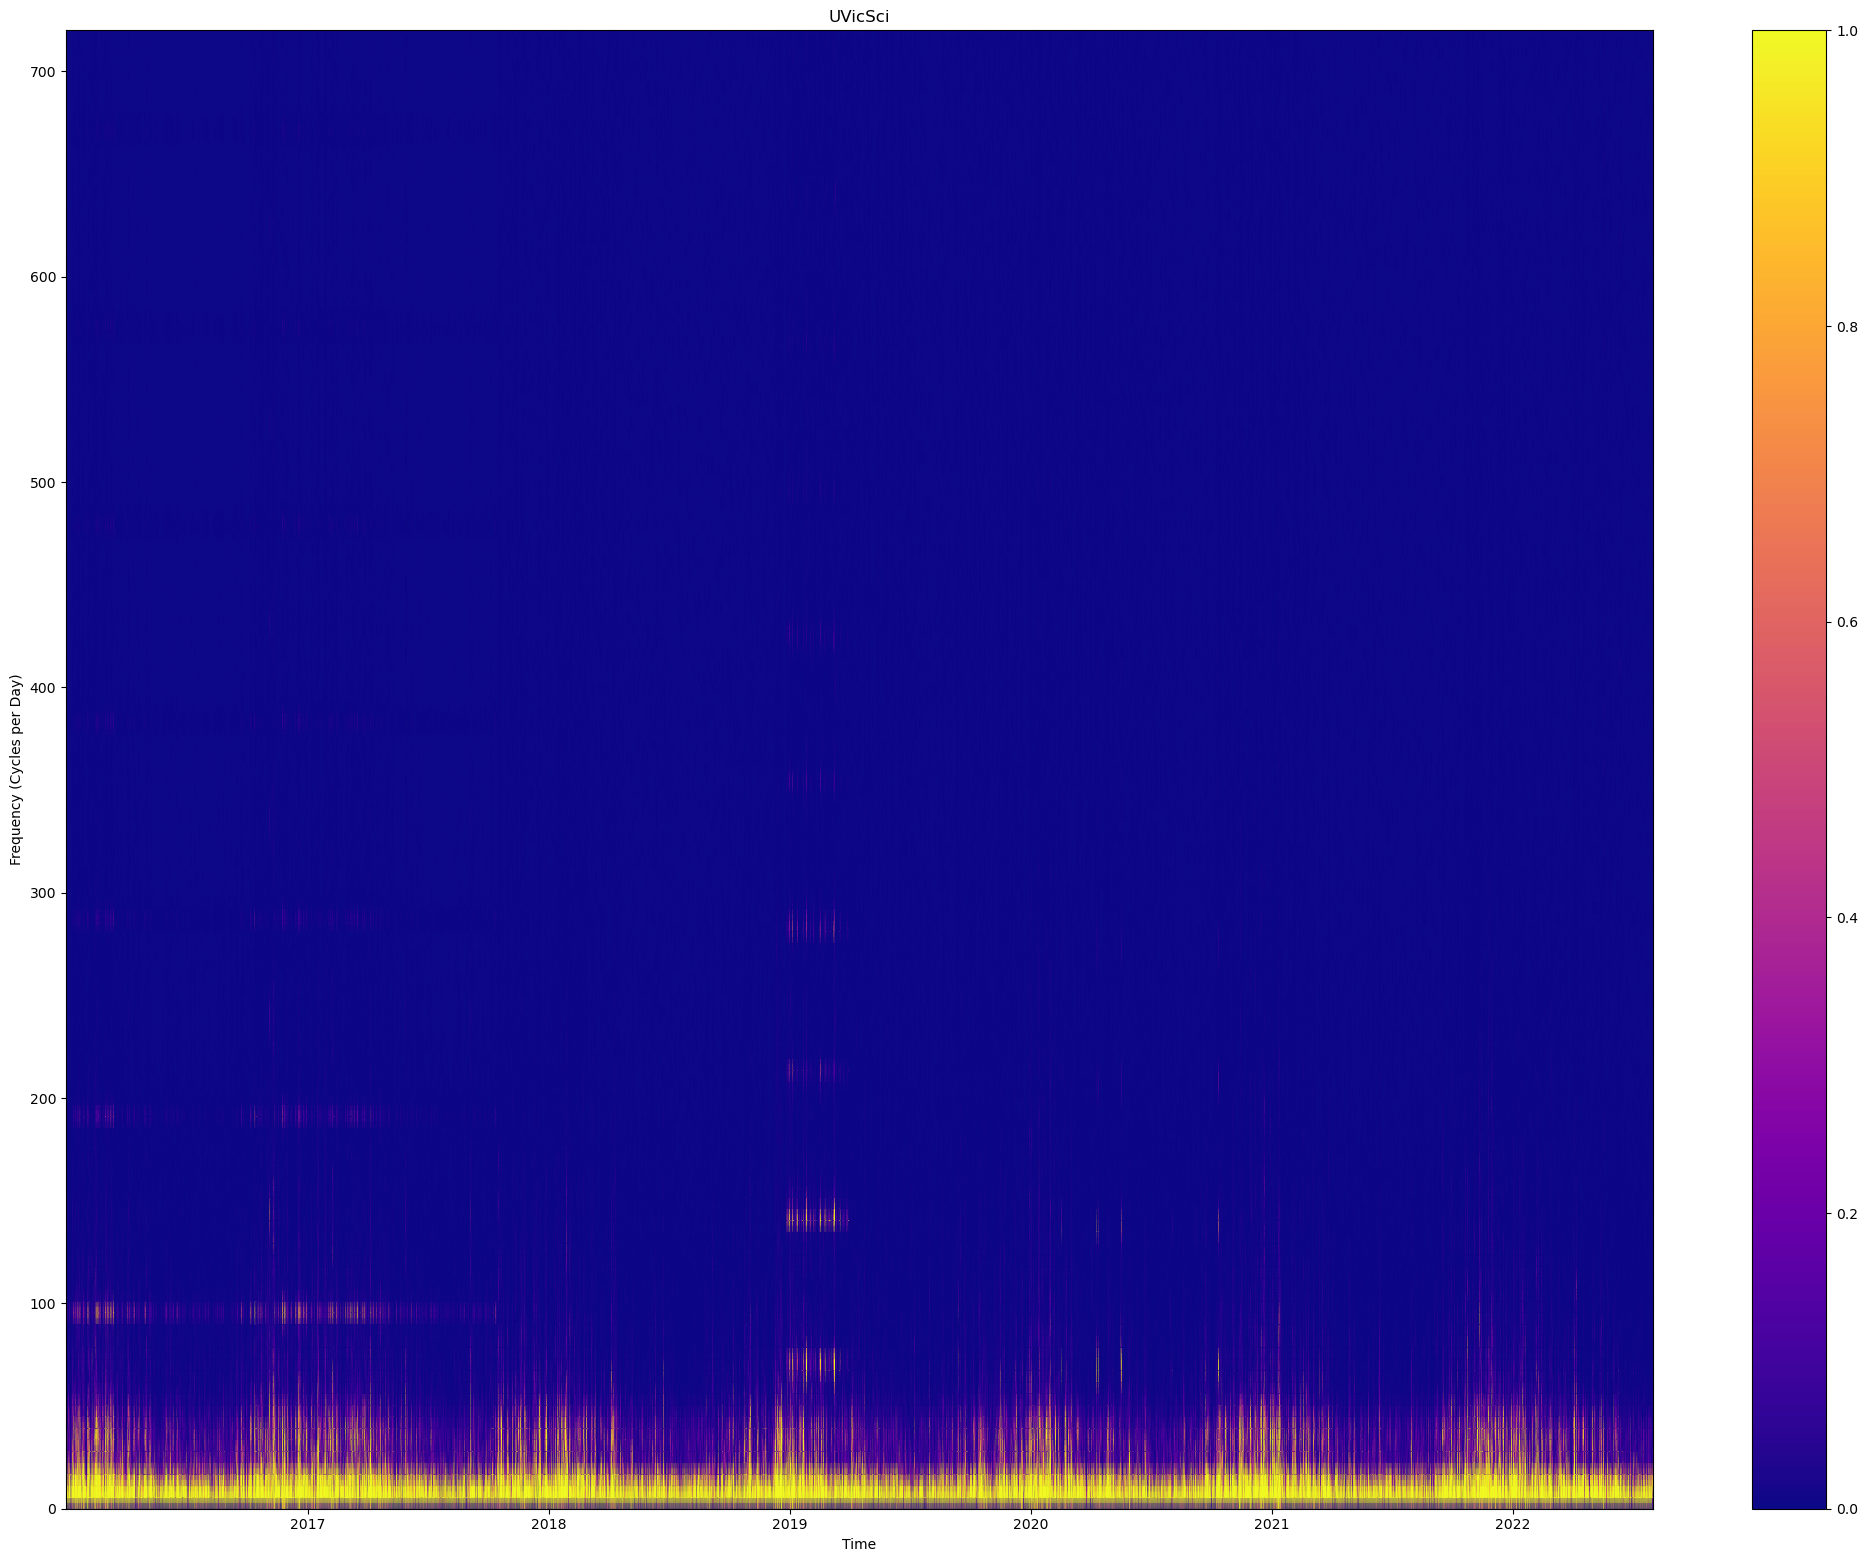

In [25]:
#plotting spectrograms

for i,name in enumerate(stations[:-1]):
    fig = plt.figure(figsize=(4*6.4,4*4.8),)
    f,t,Sxx = sig.spectrogram(press[i])
    plt.pcolormesh(np.array(tt_mins)[np.array(t,dtype=int)],f*1440,Sxx,shading='gouraud',vmin=0,vmax=1,cmap='plasma')
    plt.xlabel('Time');plt.ylabel("Frequency (Cycles per Day)");plt.title(name)
    plt.savefig('Figures/spectrogram_press'+name+'.png')
    plt.clf()



f,t,Sxx = sig.spectrogram(press[i+1])
plt.pcolormesh(np.array(tt_mins)[np.array(t,dtype=int)],f*1440,Sxx,shading='gouraud',vmin=0,vmax=1,cmap='plasma')
plt.colorbar();plt.xlabel('Time');plt.ylabel("Frequency (Cycles per Day)");plt.title(stations[i+1])
plt.savefig('Figures/spectrogram_press'+stations[i+1]+'.png')

In [4]:
# HOURLY DATA: for spatial analyses

tt_hrs,temps,press,locs,coast = projectscript.get_hour_data()
temps_demeaned = demean(temps)
press_demeaned = demean(press)

C_temp = np.cov(temps_demeaned,rowvar=False)
C_press = np.cov(press_demeaned,rowvar=False)

In [5]:
# splitting time series into seasons for further analysis

months = np.array([ti.month for ti in tt_hrs])

fall = np.where((months >=9) & (months <=11))[0]
winter = np.where((months >=12) | (months <=2))[0]
spring = np.where((months >=3) & (months <=5))[0]
summer = np.where((months >=6) & (months <=8))[0]

seasons = ['fall','winter','spring','summer']
seasons_inds = [fall,winter,spring,summer]
temp_avg = {}
press_avg = {}



In [6]:
for i,inds in enumerate(seasons_inds):
    temp_avg[seasons[i]] = np.nanmean(temps[inds],axis=0)
    press_avg[seasons[i]] = np.nanmean(press[inds],axis=0)

In [7]:
x = np.linspace(min(coast.T[0]-0.5),max(coast.T[0]+0.5),120)
y = np.linspace(min(coast.T[1]-0.5),max(coast.T[1]+0.5),100)

grid_coords = np.array([[xi,yi] for xi in x for yi in y])


In [8]:
# creating 2D grid for spatial plotting
SIGMA = 0.2

#W = np.array([[np.exp(-((xg-xp)**2 + (yg-yp)**2)/(2*SIGMA**2)) for (xp,yp) in locs] for (xg,yg) in grid_coords])
W = np.array([[1/((xg-xp)**2 + (yg-yp)**2) for (xp,yp) in locs] for (xg,yg) in grid_coords])
norm = np.sum(W,axis=1) 
W = np.array([list(W[i])/norm[i] for i in range(W.shape[0])])


In [9]:
temp_interps = {}
press_interps = {}

ncols = x.shape[0]
nrows = y.shape[0]
for season in seasons:
    temp_interps[season] = np.sum((temp_avg[season])*W,axis=1).reshape((ncols,nrows))
    press_interps[season] = np.sum((press_avg[season])*W,axis=1).reshape((ncols,nrows))

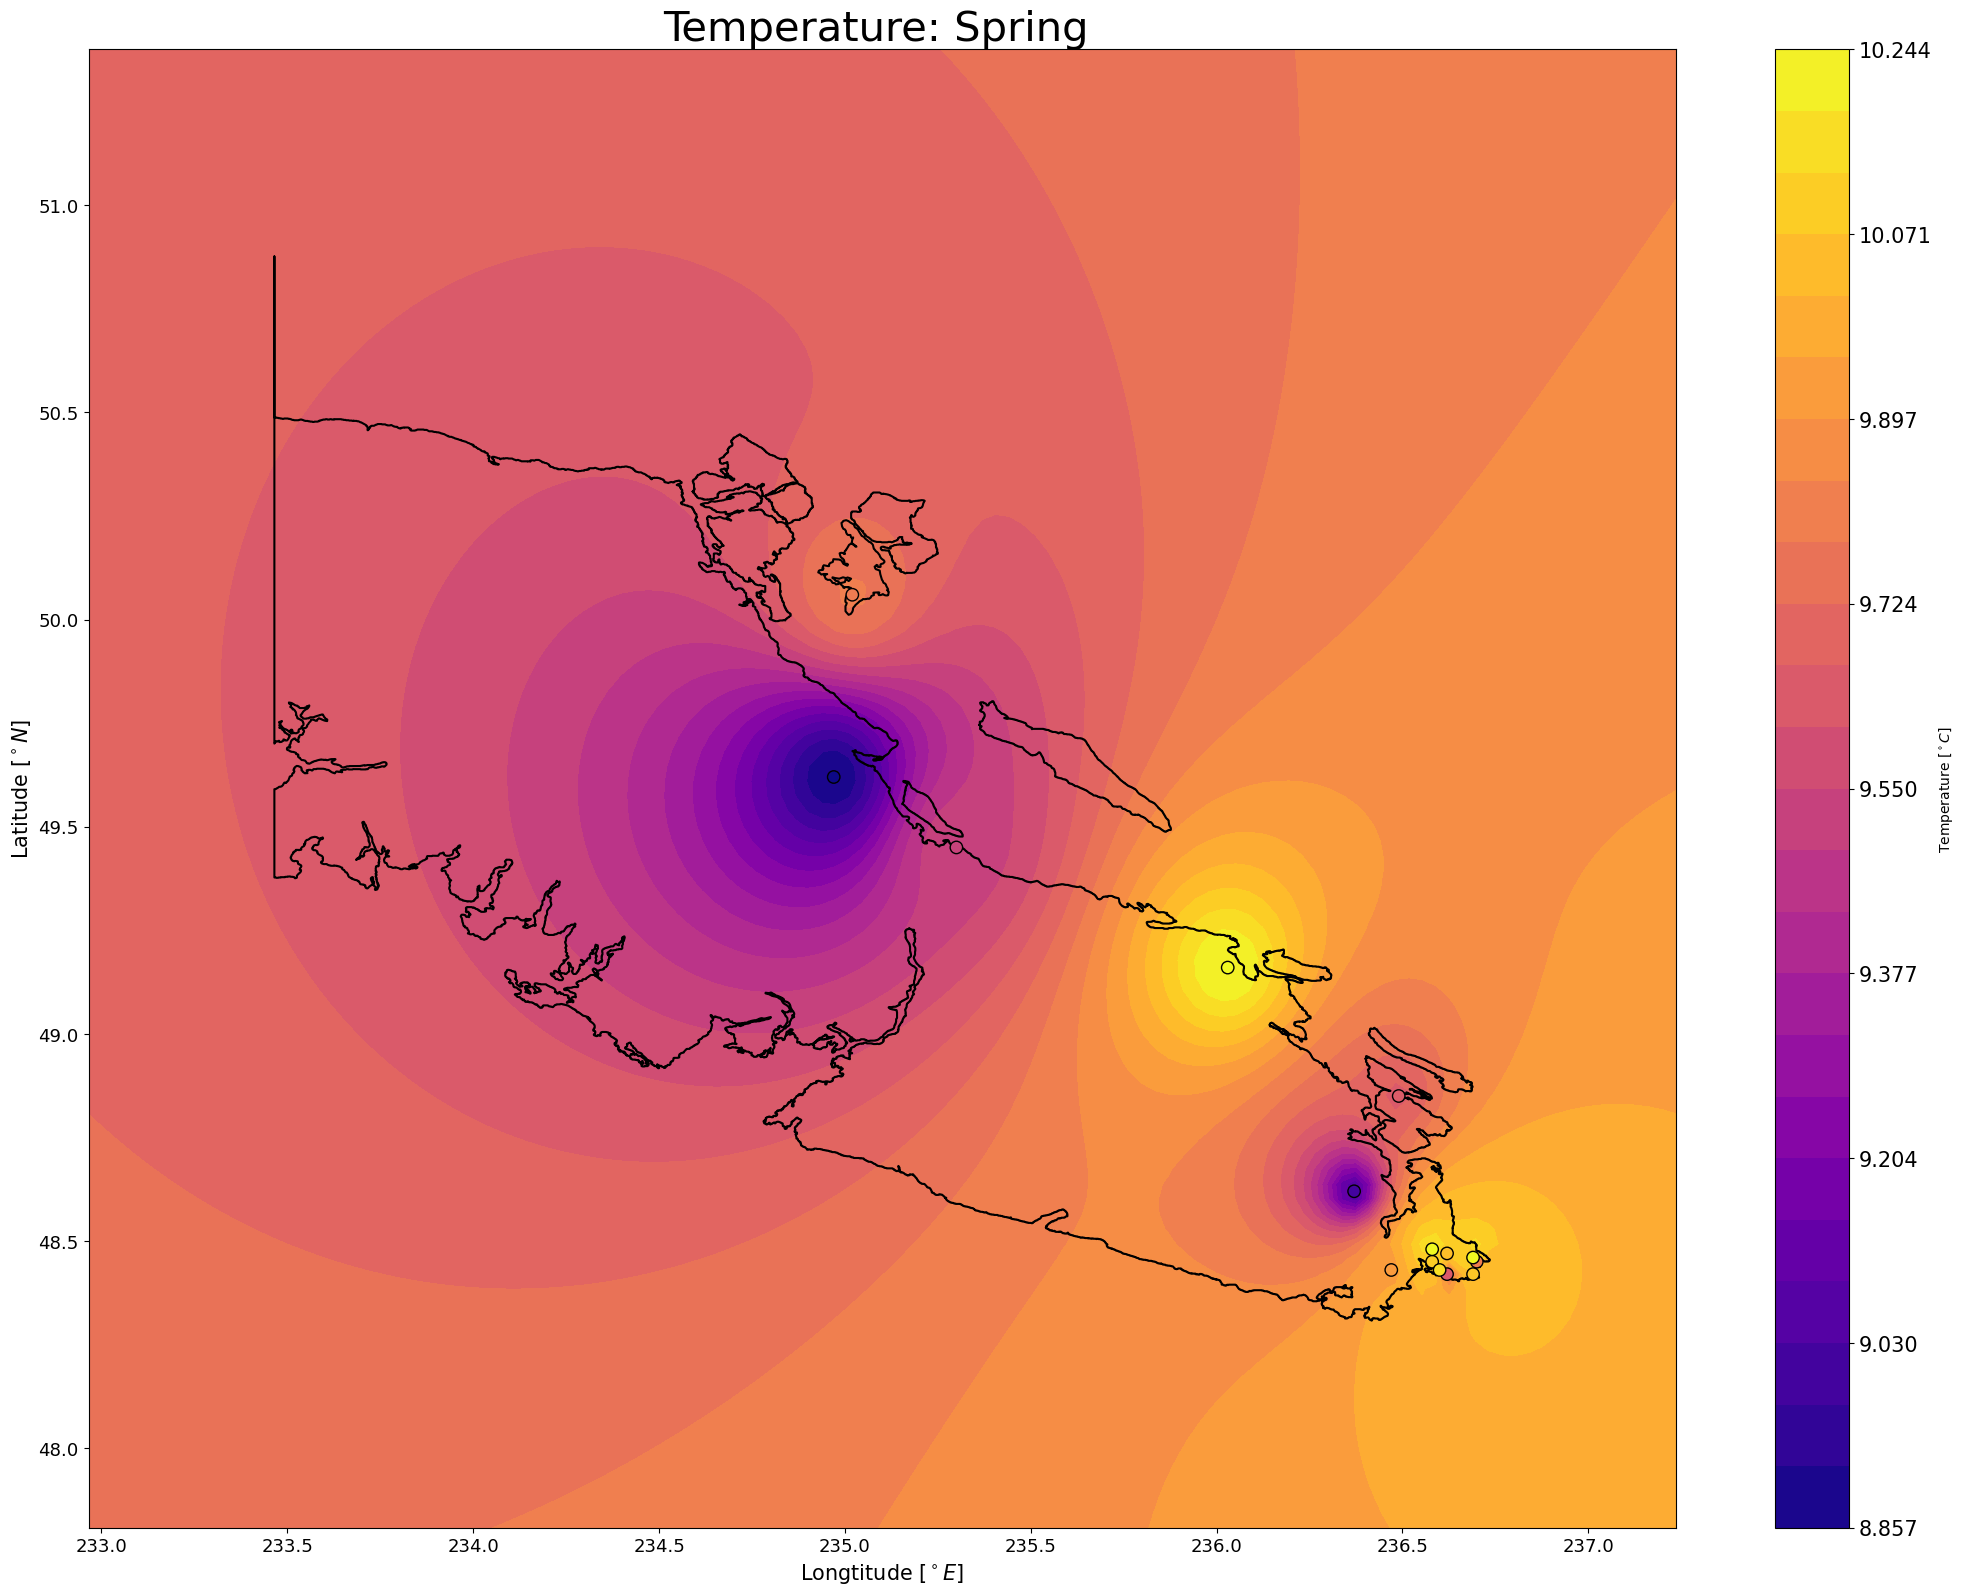

In [10]:
season = 'spring'
colormap = 'plasma'
tmin = np.min(temp_interps[season])
tmax = np.max(temp_interps[season])
clevels = np.linspace(tmin,tmax,25)


fig = plt.figure(figsize=(4*6.4,4*4.8))

plt.contourf(x,y,temp_interps[season].T,cmap=colormap,levels=clevels,vmin=tmin,vmax=tmax)
plt.colorbar(label="Temperature [$ ^\circ C$]")
fig.figure.axes[1].tick_params(labelsize=15)


plt.plot(*coast.T,color='black')

plt.scatter(*locs.T,c=temp_avg[season],cmap=colormap,edgecolors='black',s=80,alpha=1,zorder=2,vmin=tmin,vmax=tmax)

plt.xlabel("Longtitude [$^\circ E$]",size=15)
plt.ylabel("Latitude [$^\circ N$]",size=15)
plt.xticks(size=13);plt.yticks(size=13)
plt.title("Temperature: Spring ",size=30)
plt.savefig('Figures/gridding_temp_spring.png')

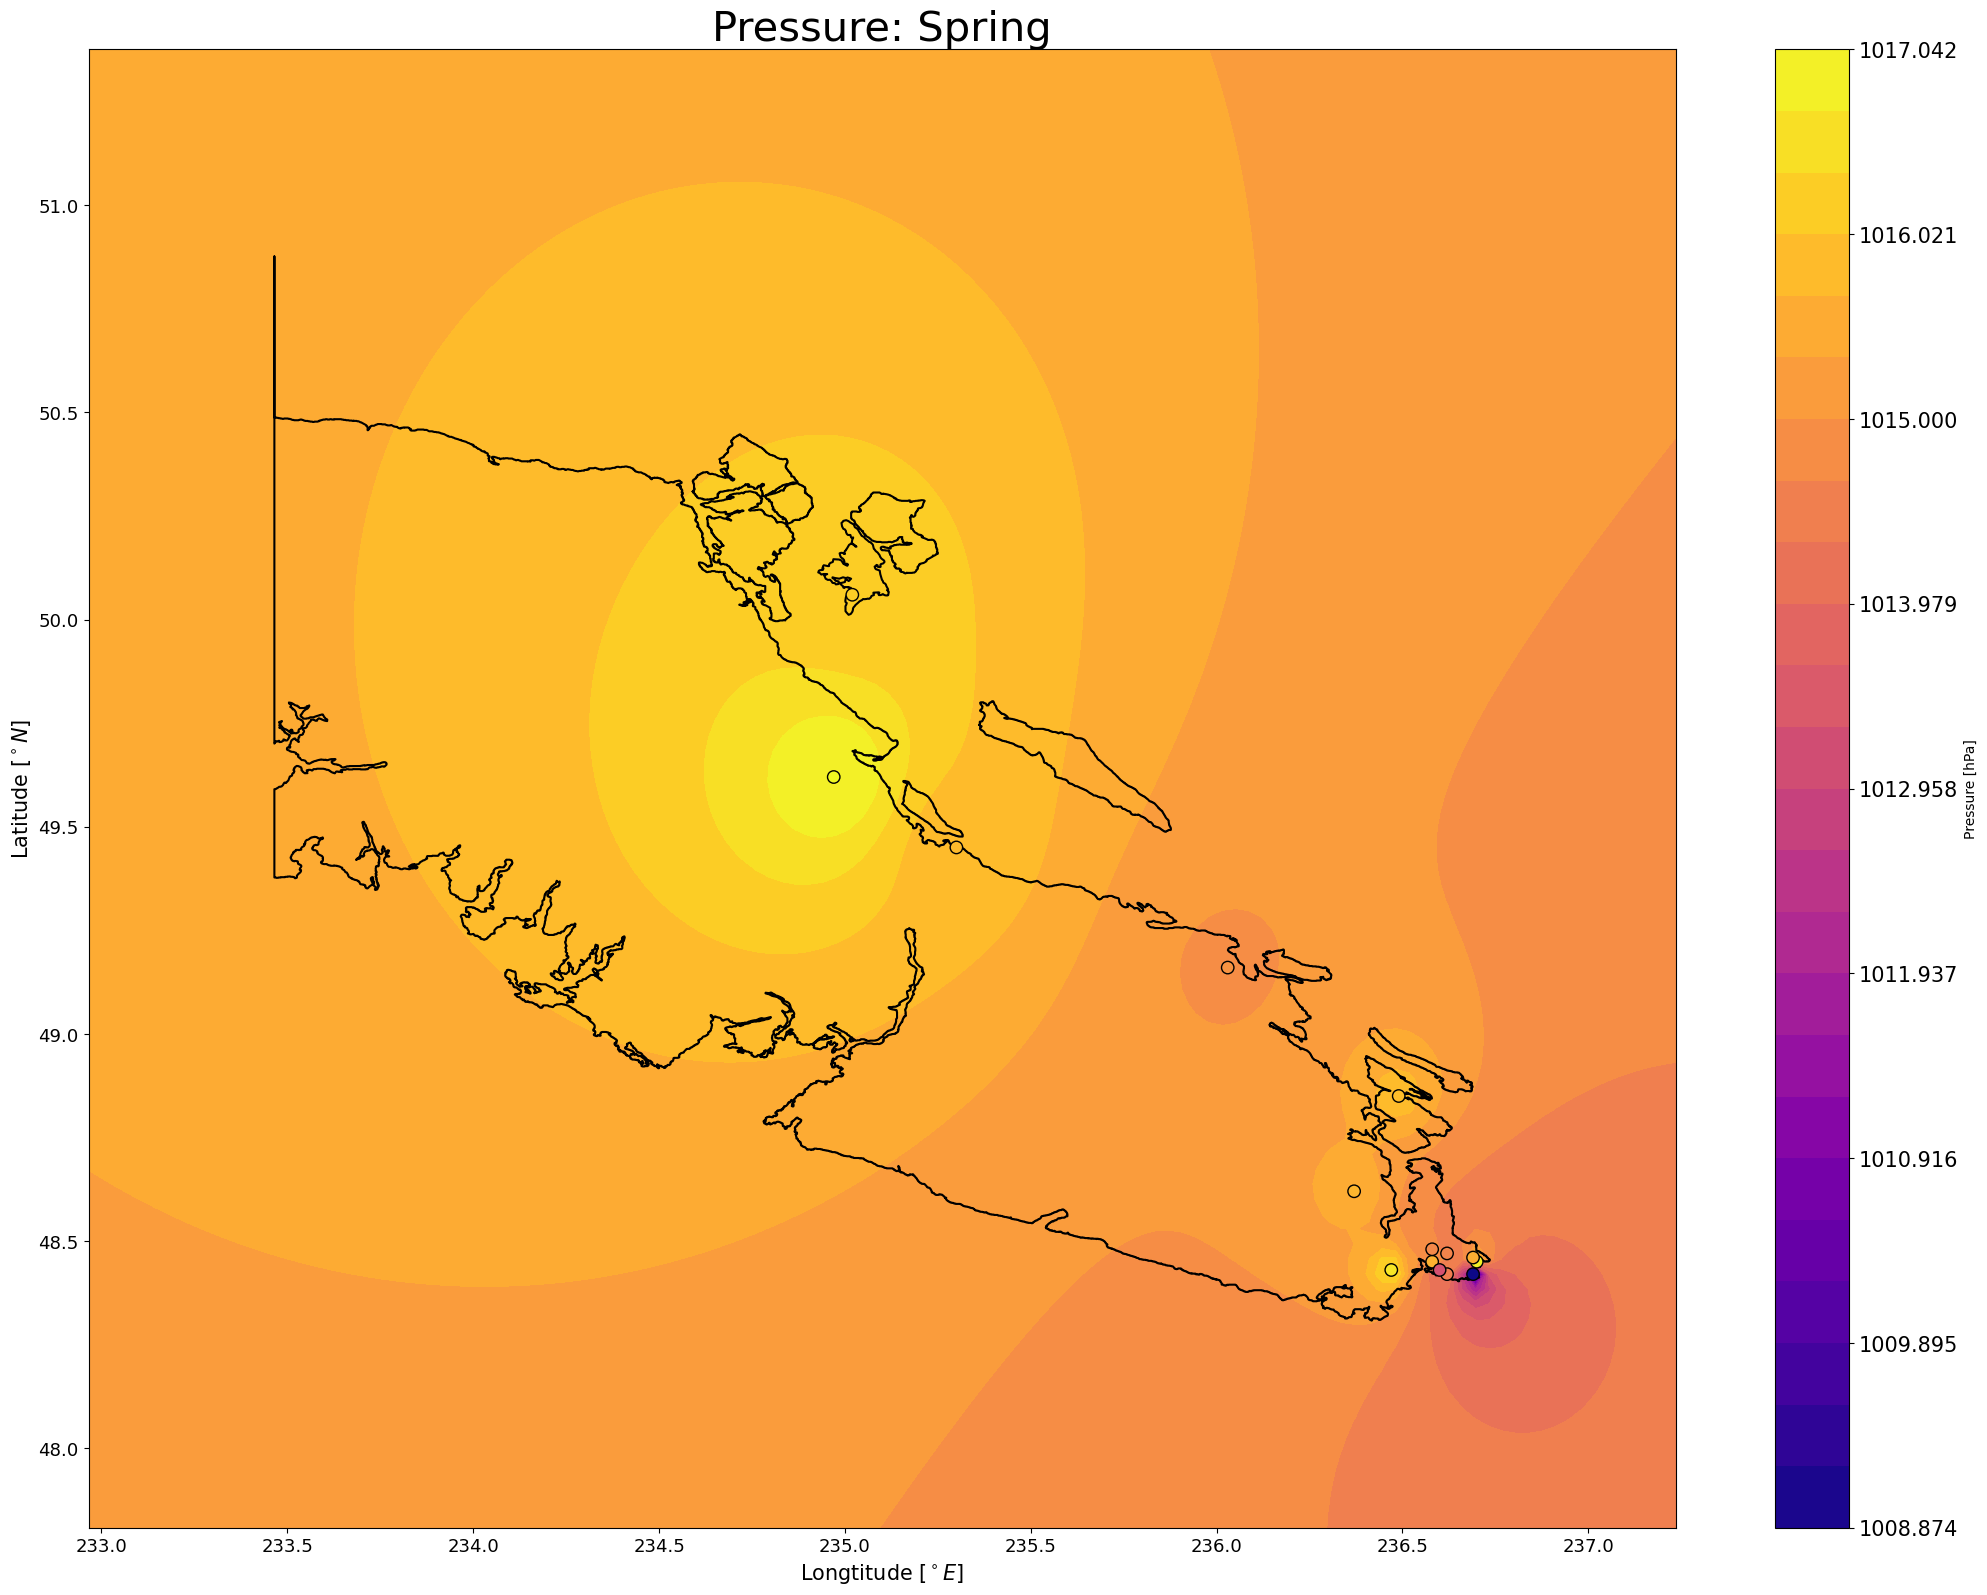

In [11]:
season = 'spring'
colormap = 'plasma'
pmin = np.min(press_interps[season])
pmax = np.max(press_interps[season])
clevels = np.linspace(pmin,pmax,25)


fig = plt.figure(figsize=(4*6.4,4*4.8))

plt.contourf(x,y,press_interps[season].T,cmap=colormap,levels=clevels,vmin=pmin,vmax=pmax)
plt.colorbar(label="Pressure [hPa]")
fig.figure.axes[1].tick_params(labelsize=15)


plt.plot(*coast.T,color='black')

plt.scatter(*locs.T,c=press_avg[season],cmap=colormap,edgecolors='black',s=80,alpha=1,zorder=2,vmin=pmin,vmax=pmax)

plt.xlabel("Longtitude [$^\circ E$]",size=15)
plt.ylabel("Latitude [$^\circ N$]",size=15)
plt.xticks(size=13);plt.yticks(size=13)
plt.title("Pressure: Spring",size=30)
plt.savefig('Figures/gridding_press_spring.png')

In [12]:
# EOF Analysis

t_lmbda, t_phi = np.linalg.eig(C_temp)
p_lmbda, p_phi = np.linalg.eig(C_press)
temp_node_vars = t_lmbda/sum(t_lmbda)
press_node_vars = p_lmbda/sum(p_lmbda)

A_temps = np.dot(temps_demeaned,np.linalg.inv(t_phi)) + np.mean(temps,axis=0)
A_press = np.dot(press_demeaned,np.linalg.inv(p_phi)) + np.mean(press,axis=0)

In [13]:
#make coords
x = np.linspace(min(coast.T[0]-0.5),max(coast.T[0]+0.5),120)
y = np.linspace(min(coast.T[1]-0.5),max(coast.T[1]+0.5),100)
grid_coords = np.array([[xi,yi] for xi in x for yi in y])
W = np.array([[1/((xg-xp)**2 + (yg-yp)**2) for (xp,yp) in locs] for (xg,yg) in grid_coords])
norm = np.sum(W,axis=1) 
W = np.array([list(W[i])/norm[i] for i in range(W.shape[0])])

In [14]:
#global gridding of eigenfunctions
temp_EOF = t_phi[:3]
press_EOF = p_phi[:3]
temp_EOF_interp = []
press_EOF_interp = []

ncols = x.shape[0]
nrows = y.shape[0]
for i in range(3):
    tmap = np.sum(temp_EOF[i]*W,axis=1).reshape((ncols,nrows))
    pmap = np.sum(press_EOF[i]*W,axis=1).reshape((ncols,nrows))
    temp_EOF_interp.append(tmap)
    press_EOF_interp.append(pmap)

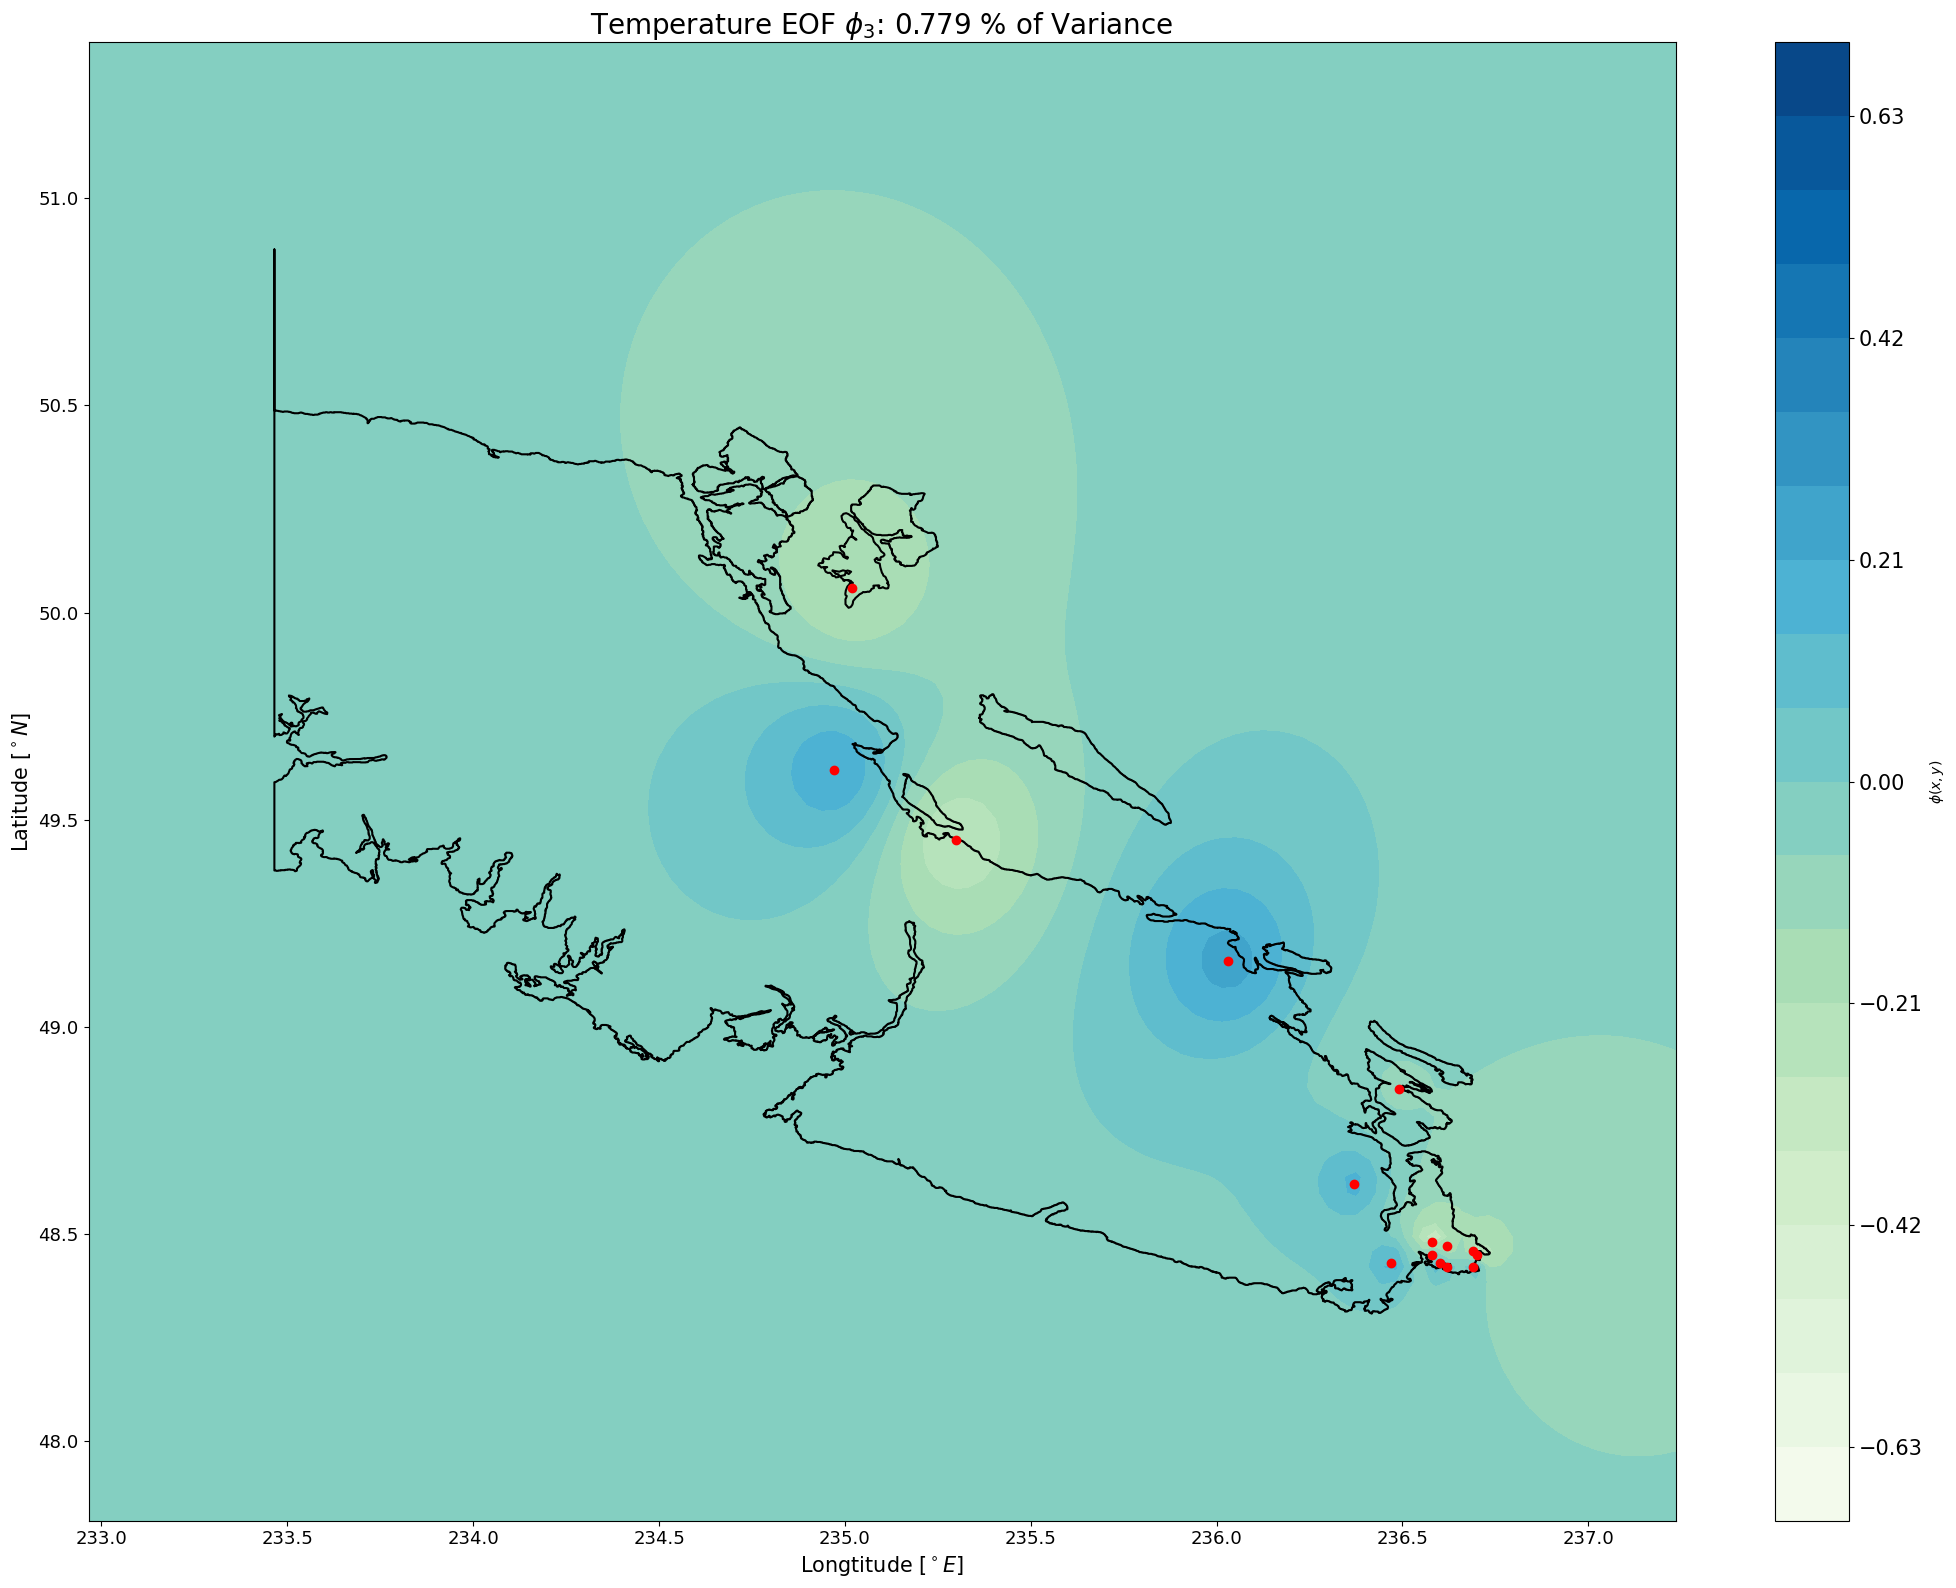

In [15]:
#global gridding of eigenfunctions
I = 2
colormap = "GnBu"

fig = plt.figure(figsize = (4*6.4,4*4.8))
clevels = np.linspace(-0.7,0.7,21)

plt.contourf(x,y,temp_EOF_interp[I].T,cmap=colormap,levels=clevels)
plt.colorbar(label="$\phi(x,y)$")
fig.figure.axes[1].tick_params(labelsize=15)

plt.plot(*coast.T,color='black')
plt.scatter(*locs.T,color='red',zorder=2)

plt.xlabel("Longtitude [$^\circ E$]",size=15)
plt.ylabel("Latitude [$^\circ N$]",size=15)
plt.xticks(size=13);plt.yticks(size=13)
plt.title("Temperature EOF $\phi_{%d}$: %.3f %% of Variance" %(I+1,temp_node_vars[I]*100),size=20)
plt.savefig("Figures/EOF_temp_%d.png" % (I+1))

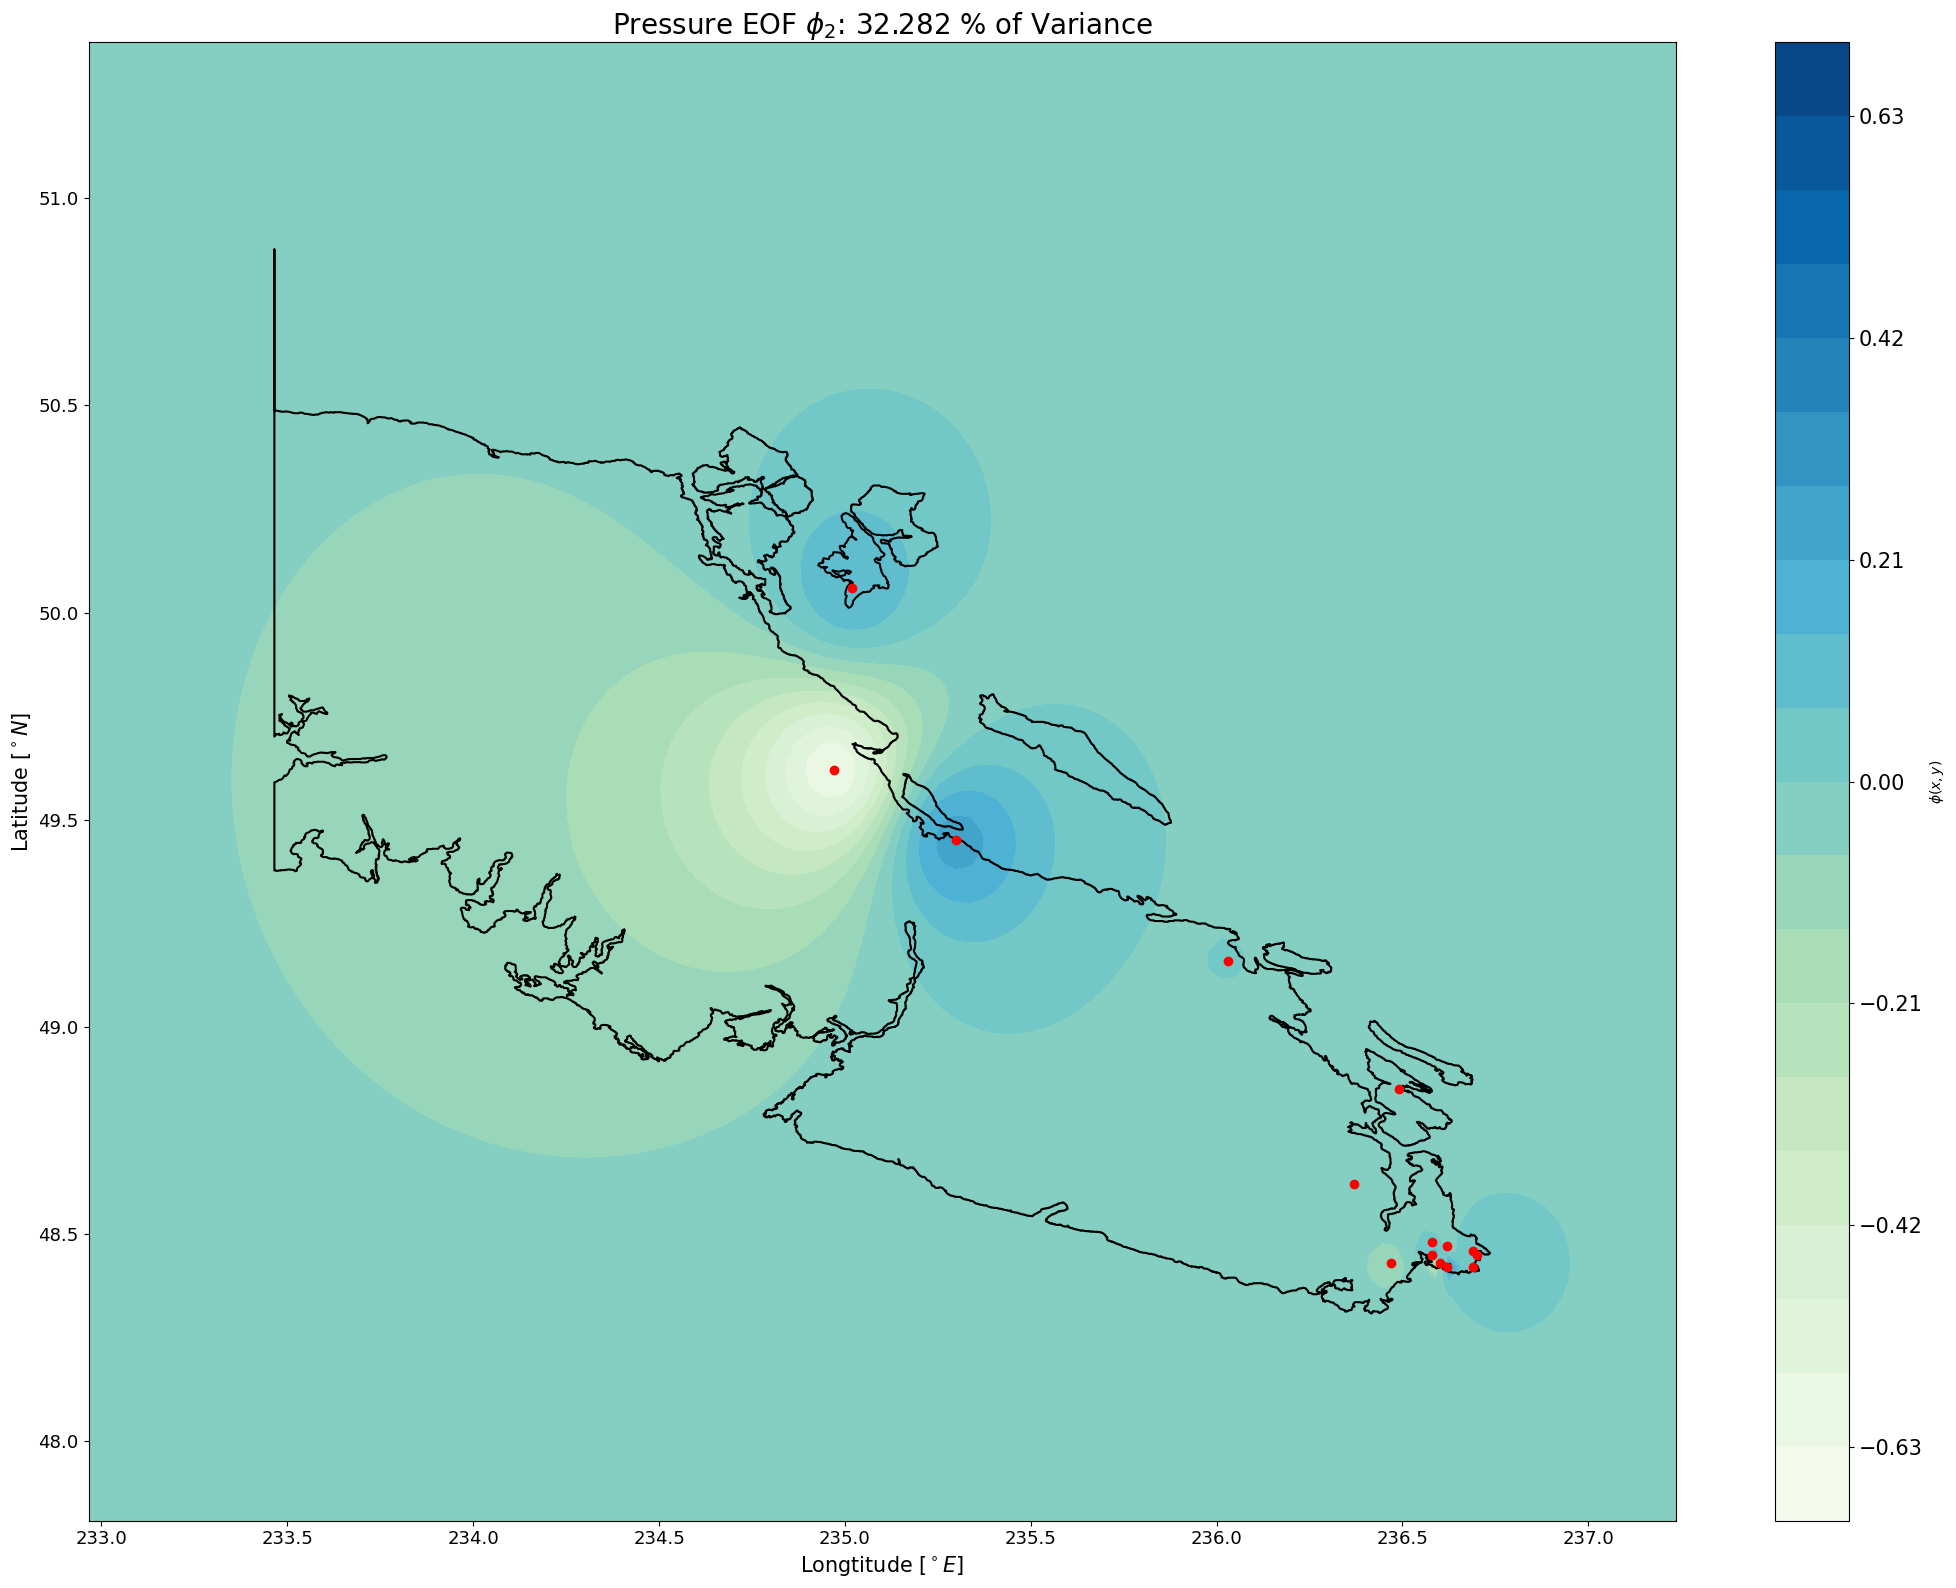

In [16]:
#global gridding of eigenfunctions
I = 1
colormap = "GnBu"

fig = plt.figure(figsize = (4*6.4,4*4.8))
clevels = np.linspace(-0.7,0.7,21)

plt.contourf(x,y,press_EOF_interp[I].T,cmap=colormap,levels=clevels)
plt.colorbar(label="$\phi(x,y)$")
fig.figure.axes[1].tick_params(labelsize=15)

plt.plot(*coast.T,color='black')
plt.scatter(*locs.T,color='red',zorder=2)

plt.xlabel("Longtitude [$^\circ E$]",size=15)
plt.ylabel("Latitude [$^\circ N$]",size=15)
plt.xticks(size=13);plt.yticks(size=13)
plt.title("Pressure EOF $\phi_{%d}$: %.3f %% of Variance" %(I+1,press_node_vars[I]*100),size=20)
plt.savefig("Figures/EOF_press_%d.png" % (I+1))

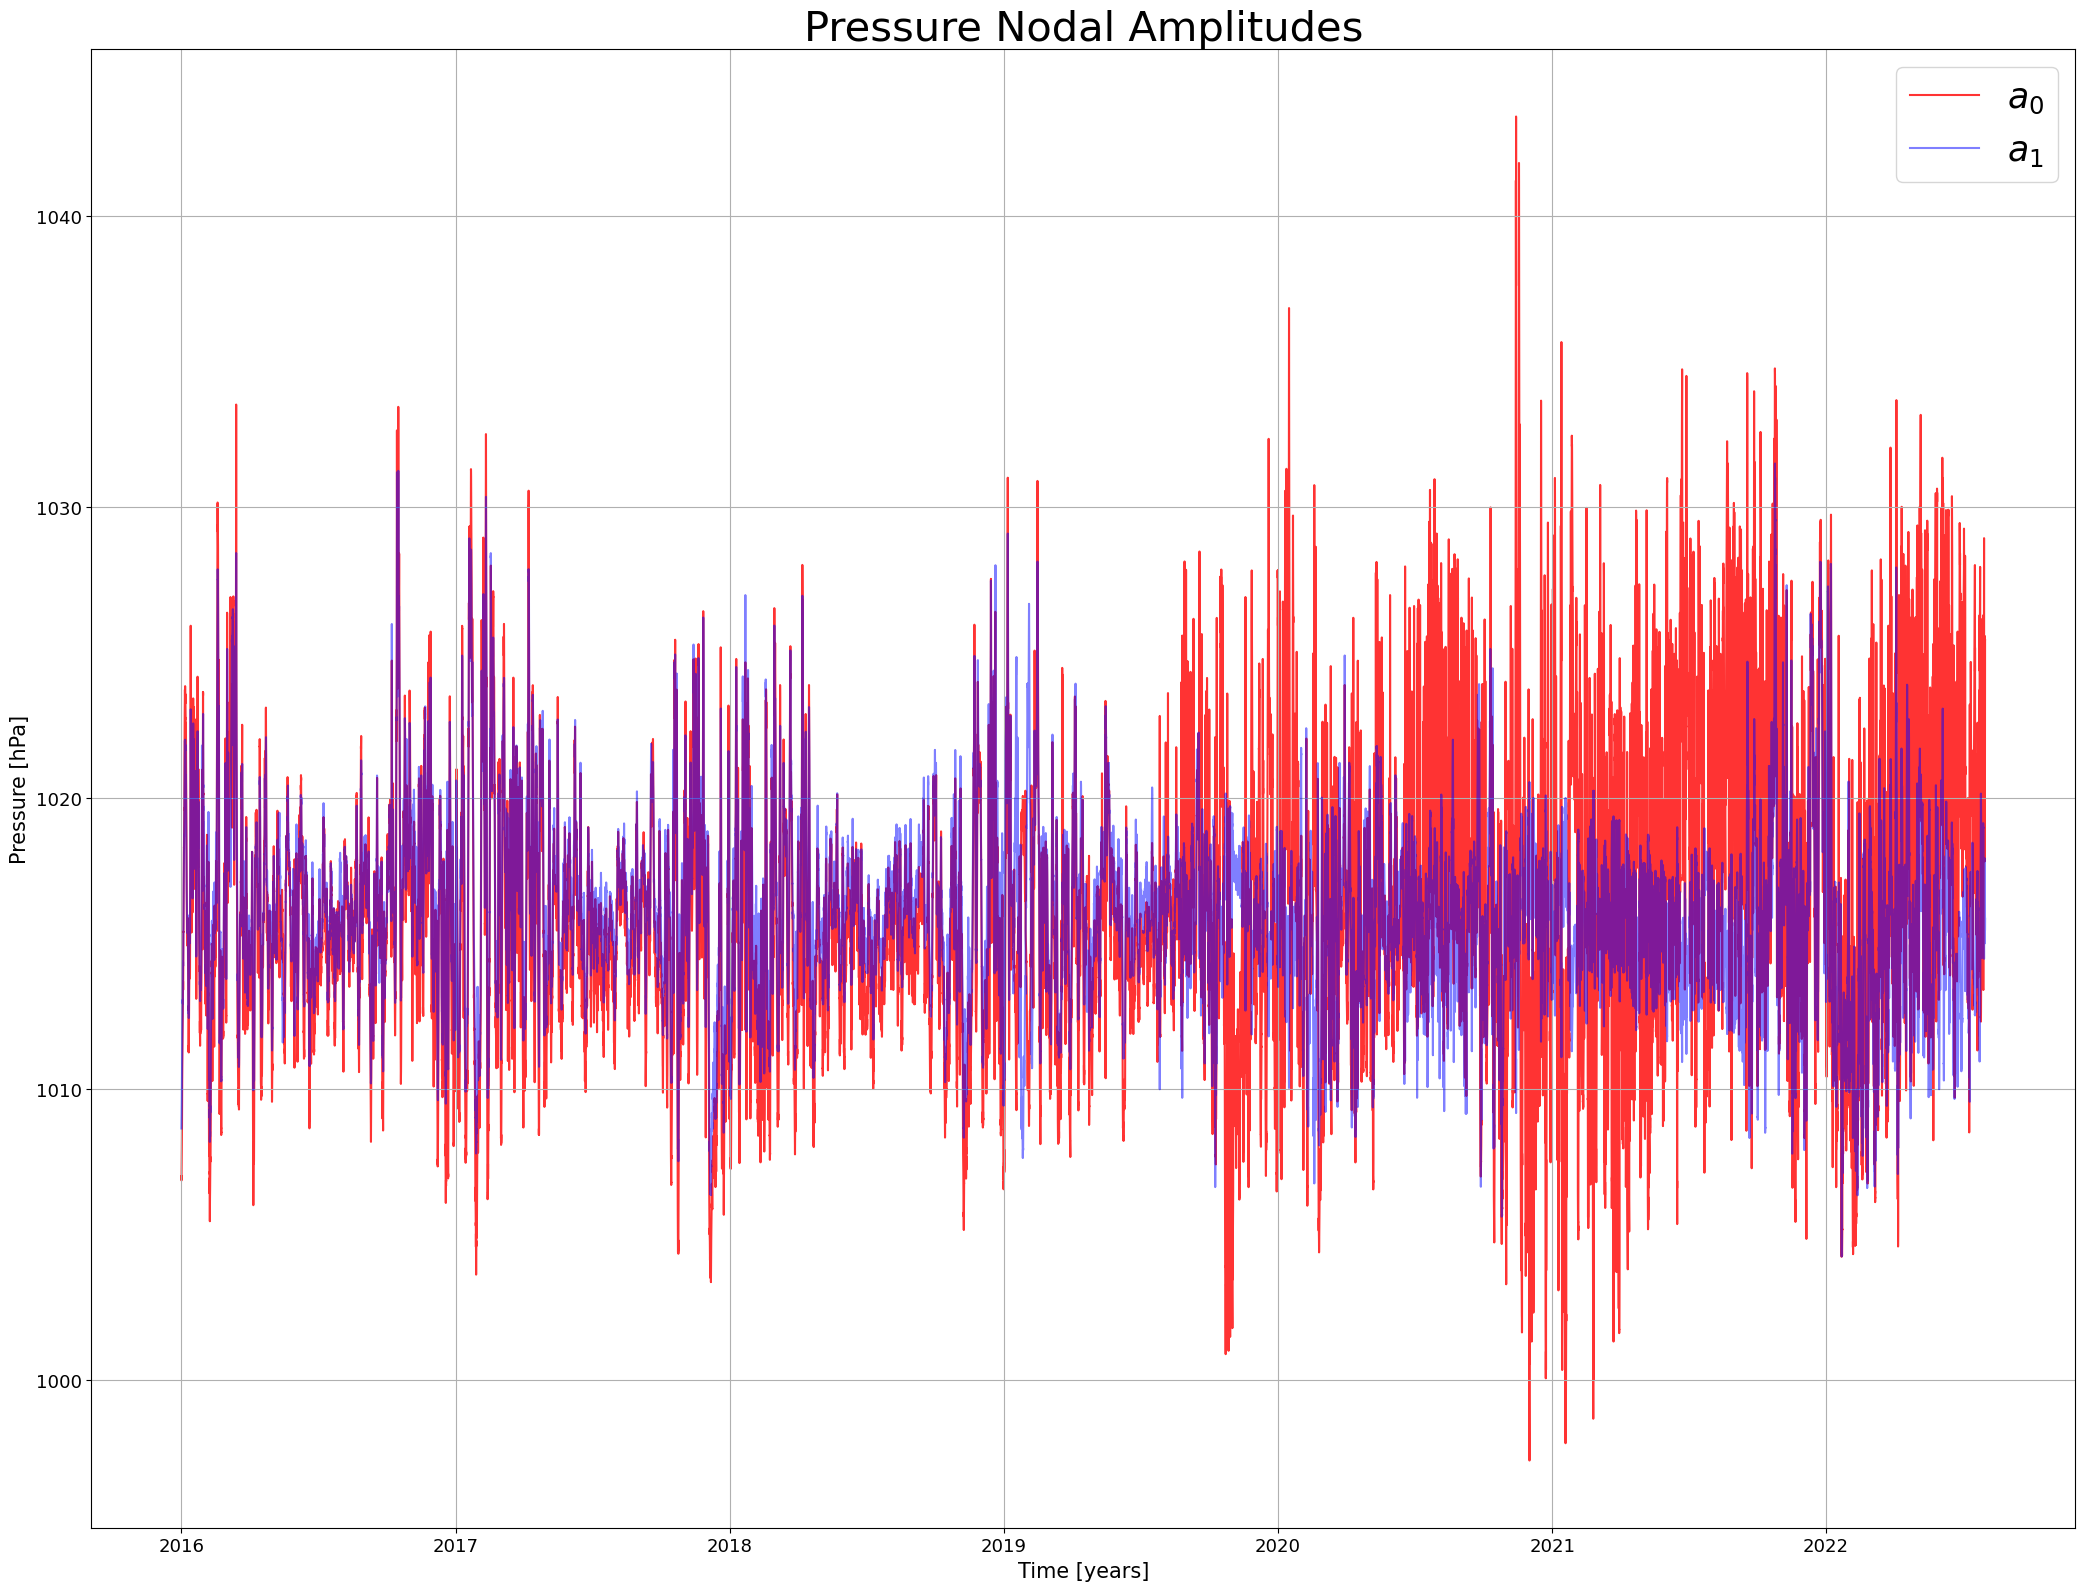

In [17]:
#amplitude time series
A_temp_EOF = A_temps.T[:3]
A_press_EOF = A_press.T[:2]

fig = plt.figure(figsize = (4*6.4,4*4.8))
plt.plot(tt_hrs,A_press_EOF[0],'-r',zorder=1,alpha=0.8,label='$a_0$')
plt.plot(tt_hrs,A_press_EOF[1],'-b',alpha=0.5,zorder=2,label='$a_1$')
#plt.plot(tt_hrs,A_press_EOF[2],'--y',alpha=0.7,zorder=3,label='$a_2$')
plt.xlabel('Time [years]',size=15);plt.ylabel("Pressure [hPa]",size=15)
plt.xticks(size=13);plt.yticks(size=13)
plt.legend(prop={'size': 25})
plt.title("Pressure Nodal Amplitudes",size=30)
plt.grid()
plt.savefig('Figures/nodeamps_press.png')
plt.show()